# 12 Object detection

In [2]:
# !pip install keras keras-hub --upgrade -q

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
import keras_hub

In [3]:
# import os
# os.environ["KERAS_BACKEND"] = "jax"

In [4]:
# # @title
# import os
# from IPython.core.magic import register_cell_magic

# @register_cell_magic
# def backend(line, cell):
#     current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
#     if current == required:
#         get_ipython().run_cell(cell)
#     else:
#         print(
#             f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
#             f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
#         )

## Object detection

### Single-stage vs. two-stage object detectors

#### Two-stage R-CNN detectors

#### Single-stage detectors

### Training a YOLO model from scratch

#### Downloading the COCO dataset

In [27]:
# the dataset is ~20Gb, it takes a while to download!
images_path = tf.keras.utils.get_file(
    "coco",
    "http://images.cocodataset.org/zips/train2017.zip",
    extract=True,
)
annotations_path = tf.keras.utils.get_file(
    "annotations",
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip",
    extract=True,
)

19336861798/19336861798 ━━━━━━━━━━━━━━━━━━━━ 2446s 0us/step


In [28]:
import json

with open(f"{annotations_path}/annotations/instances_train2017.json", "r") as f:
    annotations = json.load(f)

images = {image["id"]: image for image in annotations["images"]}

def scale_box(box, width, height):
    """
    Converts bounding box to coordinates on a unit square
    """
    scale = 1.0 / max(width, height)
    x, y, w, h = [v * scale for v in box]
    # correct either x or y (one of the two dims will be adjusted to
    # make the image square, see `draw_image` below)
    x += (height - width) * scale / 2 if height > width else 0
    y += (width - height) * scale / 2 if width > height else 0
    return [x, y, w, h]

# Aggregates all bounding box annotations by image ID
metadata = {}
for annotation in annotations["annotations"]:
    id = annotation["image_id"]
    if id not in metadata:
        metadata[id] = {"boxes": [], "labels": []}
    image = images[id]
    box = scale_box(annotation["bbox"], image["width"], image["height"])
    metadata[id]["boxes"].append(box)
    metadata[id]["labels"].append(annotation["category_id"])
    metadata[id]["path"] = images_path + "/train2017/" + image["file_name"]
metadata = list(metadata.values())

In [29]:
len(metadata)

117266

In [30]:
min([len(x["boxes"]) for x in metadata])

1

In [31]:
max([len(x["boxes"]) for x in metadata])

93

In [32]:
max(max(x["labels"]) for x in metadata) + 1

91

In [33]:
n = 435
# n = np.random.randint(0, len(metadata))
metadata[n]

{'boxes': [[0.12471874999999999, 0.275, 0.57640625, 0.333703125],
  [0.0, 0.152078125, 0.7938125, 0.687640625],
  [0.0, 0.125140625, 1.0, 0.7498593750000001]],
 'labels': [17, 15, 2],
 'path': '/Users/jcw/.keras/datasets/coco/train2017/000000171809.jpg'}

In [16]:
[keras_hub.utils.coco_id_to_name(x) for x in metadata[435]["labels"]]

['cat', 'bench', 'bicycle']

In [52]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.patches import Rectangle

color_map = {0: "gray"}

def label_to_color(label):
    # Uses the golden ratio to generate new hues of a bright color with
    # the HSV colorspace    
    if label not in color_map:
        h, s, v = (len(color_map) * 0.618) % 1, 0.5, 0.9
        color_map[label] = hsv_to_rgb((h, s, v))
    return color_map[label]

def draw_box(ax, box, text, color):
    x, y, w, h = box
    ax.add_patch(Rectangle((x, y), w, h, lw=1, ec=color, fc="none"))
    textbox = dict(fc=color, pad=1, ec="none")
    ax.text(x + w, y, text, c="white", size=8, va="top", ha="right", bbox=textbox)

def draw_image(ax, image):
    """
    Draws the image on a unit cube with (0, 0) at the top left
    """
    ax.set(xlim=(0, 1), ylim=(1, 0), xticks=[], yticks=[], aspect="equal")
    image = plt.imread(image)
    height, width = image.shape[:2]
    # Pads the image so it fits inside the unit square
    hpad = (1 - height / width) / 2 if width > height else 0
    wpad = (1 - width / height) / 2 if height > width else 0
    extent = [wpad, 1 - wpad, 1 - hpad, hpad]
    ax.imshow(image, extent=extent)

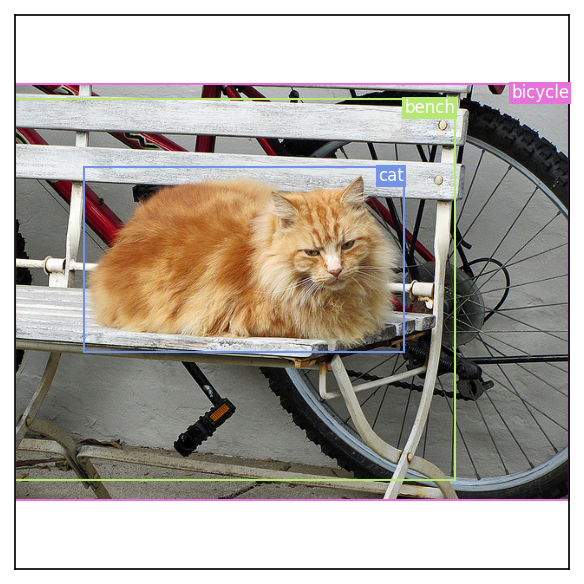

In [53]:
sample = metadata[435]
ig, ax = plt.subplots(dpi=150)
draw_image(ax, sample["path"])
for box, label in zip(sample["boxes"], sample["labels"]):
    label_name = keras_hub.utils.coco_id_to_name(label)
    draw_box(ax, box, label_name, label_to_color(label))
plt.show()

In [56]:
import random

metadata = list(filter(lambda x: len(x["boxes"]) <= 4, metadata))
random.shuffle(metadata)

#### Creating a YOLO model

![YOLO outputs, figure from the paper](images/chollet/figure12.4.png)

<!-- <img src="https://raw.githubusercontent.com/jchwenger/AI/refs/heads/main/lectures/05.more/images/chollet/figure12.4.png"> -->

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter12_object-detection/#creating-a-yolo-model), Chapter 12, Figure 12.4</small>

In [59]:
IMAGE_SIZE = 448

backbone = keras_hub.models.Backbone.from_preset(
    "resnet_50_imagenet",
)
preprocessor = keras_hub.layers.ImageConverter.from_preset(
    "resnet_50_imagenet",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
)

In [78]:
from keras import layers

GRID_SIZE = 6
NUM_LABELS = 91

inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = backbone(inputs)
# Makes our backbone outputs smaller and then flattens the output
# features
x = layers.Conv2D(512, (3, 3), strides=(2, 2))(x)
x = keras.layers.Flatten()(x)
# Passes our flattened feature maps through two densely connected
# layers
x = layers.Dense(2048, activation="relu", kernel_initializer="glorot_normal")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(GRID_SIZE * GRID_SIZE * (NUM_LABELS + 5))(x)
# Reshapes outputs to a 6 × 6 grid
x = layers.Reshape((GRID_SIZE, GRID_SIZE, NUM_LABELS + 5))(x)
# Split box (cx, cy, w, h) and class predictions
box_predictions = x[..., :5]
class_predictions = layers.Activation("softmax")(x[..., 5:])
outputs = {"box": box_predictions, "class": class_predictions}
model = keras.Model(inputs, outputs)

In [61]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 448, 448,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_net_backbone    │ (None, 14, 14,    │ 23,561,152 │ input_layer_2[0]… │
│ (ResNetBackbone)    │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 6, 6, 512) │  9,437,696 │ res_net_backbone… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18432)     │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │ 37,750,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3456)      │  7,081,344 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 6, 96)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 6, 6, 91)  │          0 │ reshape[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 6, 6, 5)   │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 6, 6, 91)  │          0 │ get_item_1[0][0]  │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,830,976 (296.90 MB)

 Trainable params: 77,777,856 (296.70 MB)

 Non-trainable params: 53,120 (207.50 KB)

#### Readying the COCO data for the YOLO model

In [62]:
def to_grid(box):
    """
    Convert the normalised `x, y, w, h` to their grid-sized equivalent
    """
    x, y, w, h = box
    cx, cy = (x + w / 2) * GRID_SIZE, (y + h / 2) * GRID_SIZE
    ix, iy = int(cx), int(cy)
    return (ix, iy), (cx - ix, cy - iy, w, h)

def from_grid(loc, box):
    """
    Convert the grid-sized `x, y, w, h` to their normalized equivalent
    """    
    (xi, yi), (x, y, w, h) = loc, box
    x = (xi + x) / GRID_SIZE - w / 2
    y = (yi + y) / GRID_SIZE - h / 2
    return (x, y, w, h)

In [63]:
import numpy as np
import math

class_array = np.zeros((len(metadata), GRID_SIZE, GRID_SIZE))
box_array = np.zeros((len(metadata), GRID_SIZE, GRID_SIZE, 5))

for index, sample in enumerate(metadata):
    boxes, labels = sample["boxes"], sample["labels"]
    for box, label in zip(boxes, labels):
        (x, y, w, h) = box
        left, right = math.floor(x * GRID_SIZE), math.ceil((x + w) * GRID_SIZE)
        bottom, top = math.floor(y * GRID_SIZE), math.ceil((y + h) * GRID_SIZE)
        class_array[index, bottom:top, left:right] = label

for index, sample in enumerate(metadata):
    boxes, labels = sample["boxes"], sample["labels"]
    for box, label in zip(boxes, labels):
        (xi, yi), (grid_box) = to_grid(box)
        box_array[index, yi, xi] = [*grid_box, 1.0]
        class_array[index, yi, xi] = label

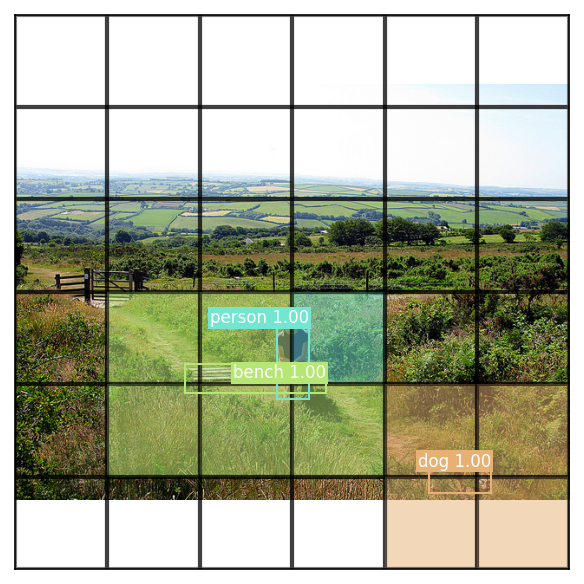

In [64]:
def draw_prediction(image, boxes, classes, cutoff=None):
    fig, ax = plt.subplots(dpi=150)
    draw_image(ax, image)
    for yi, row in enumerate(classes):
        for xi, label in enumerate(row):
            color = label_to_color(label) if label else "none"
            x, y, w, h = (v / GRID_SIZE for v in (xi, yi, 1.0, 1.0))
            r = Rectangle((x, y), w, h, lw=2, ec="black", fc=color, alpha=0.5)
            ax.add_patch(r)
    for yi, row in enumerate(boxes):
        for xi, box in enumerate(row):
            box, confidence = box[:4], box[4]
            if not cutoff or confidence >= cutoff:
                box = from_grid((xi, yi), box)
                label = classes[yi, xi]
                color = label_to_color(label)
                name = keras_hub.utils.coco_id_to_name(label)
                draw_box(ax, box, f"{name} {max(confidence, 0):.2f}", color)
    plt.show()

draw_prediction(metadata[0]["path"], box_array[0], class_array[0], cutoff=1.0)

In [65]:
def load_image(path):
    x = tf.io.read_file(path)
    x = tf.image.decode_jpeg(x, channels=3)
    return preprocessor(x)

images = tf.data.Dataset.from_tensor_slices([x["path"] for x in metadata])
images = images.map(load_image, num_parallel_calls=8)
labels = {"box": box_array, "class": class_array}
labels = tf.data.Dataset.from_tensor_slices(labels)

dataset = tf.data.Dataset.zip(images, labels).batch(16).prefetch(2)
val_dataset, train_dataset = dataset.take(500), dataset.skip(500)

#### Training the YOLO model

In [69]:
def unpack(box):
    return box[..., 0], box[..., 1], box[..., 2], box[..., 3]

def intersection(box1, box2):
    cx1, cy1, w1, h1 = unpack(box1)
    cx2, cy2, w2, h2 = unpack(box2)
    left = tf.math.maximum(cx1 - w1 / 2, cx2 - w2 / 2)
    bottom = tf.math.maximum(cy1 - h1 / 2, cy2 - h2 / 2)
    right = tf.math.minimum(cx1 + w1 / 2, cx2 + w2 / 2)
    top = tf.math.minimum(cy1 + h1 / 2, cy2 + h2 / 2)
    return tf.math.maximum(0.0, right - left) * tf.math.maximum(0.0, top - bottom)

def intersection_over_union(box1, box2):
    cx1, cy1, w1, h1 = unpack(box1)
    cx2, cy2, w2, h2 = unpack(box2)
    intersection_area = intersection(box1, box2)
    a1 = tf.math.maximum(w1, 0.0) * tf.math.maximum(h1, 0.0)
    a2 = tf.math.maximum(w2, 0.0) * tf.math.maximum(h2, 0.0)
    union_area = a1 + a2 - intersection_area
    return tf.math.divide_no_nan(intersection_area, union_area)

In [138]:
def signed_sqrt(x):
    return  tf.math.sign(x) *  tf.math.sqrt(tf.math.abs(x) + keras.config.epsilon())

# required to serialise the model
@keras.saving.register_keras_serializable()
def box_loss(true, pred):
    xy_true, wh_true, conf_true = true[..., :2], true[..., 2:4], true[..., 4:]
    xy_pred, wh_pred, conf_pred = pred[..., :2], pred[..., 2:4], pred[..., 4:]
    no_object = conf_true == 0.0
    xy_error =  tf.math.square(xy_true - xy_pred)
    wh_error =  tf.math.square(signed_sqrt(wh_true) - signed_sqrt(wh_pred))
    iou = intersection_over_union(true, pred)
    conf_target =  tf.where(no_object, 0.0, tf.expand_dims(iou, -1))
    conf_error =  tf.square(conf_target - conf_pred)
    error = tf.keras.ops.concatenate(
        (
            tf.where(no_object, 0.0, xy_error * 5.0),
            tf.where(no_object, 0.0, wh_error * 5.0),
            tf.where(no_object, conf_error * 0.5, conf_error),
        ),
        axis=-1,
    )
    return tf.reduce_sum(error, axis=(1, 2, 3))

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4),
    loss={"box": box_loss, "class": "sparse_categorical_crossentropy"},
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "resnet_50_coco.keras"),
            save_best_only=True
        )
    ]
)

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4),
    loss={"box": box_loss, "class": "sparse_categorical_crossentropy"},
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=4,
)

Epoch 1/4
3201/3201 ━━━━━━━━━━━━━━━━━━━━ 1095s 317ms/step - box_loss: 4.7445 - class_loss: 2.5148 - loss: 7.2593 - val_box_loss: 2.1241 - val_class_loss: 1.8485 - val_loss: 3.9727
Epoch 2/4
3201/3201 ━━━━━━━━━━━━━━━━━━━━ 1005s 310ms/step - box_loss: 2.2321 - class_loss: 1.7362 - loss: 3.9683 - val_box_loss: 2.0005 - val_class_loss: 1.4747 - val_loss: 3.4752
Epoch 3/4
3201/3201 ━━━━━━━━━━━━━━━━━━━━ 1004s 310ms/step - box_loss: 1.9735 - class_loss: 1.4396 - loss: 3.4131 - val_box_loss: 1.9837 - val_class_loss: 1.2903 - val_loss: 3.2740
Epoch 4/4
3201/3201 ━━━━━━━━━━━━━━━━━━━━ 1005s 310ms/step - box_loss: 1.6964 - class_loss: 1.2480 - loss: 2.9443 - val_box_loss: 1.9817 - val_class_loss: 1.2071 - val_loss: 3.1888


In [ ]:
model_reloaded = tf.keras.models.load_model("resnet_50_coco.keras")

In [131]:
val_ds_iter = iter(val_dataset.rebatch(1))
metadata_iter = iter(metadata)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


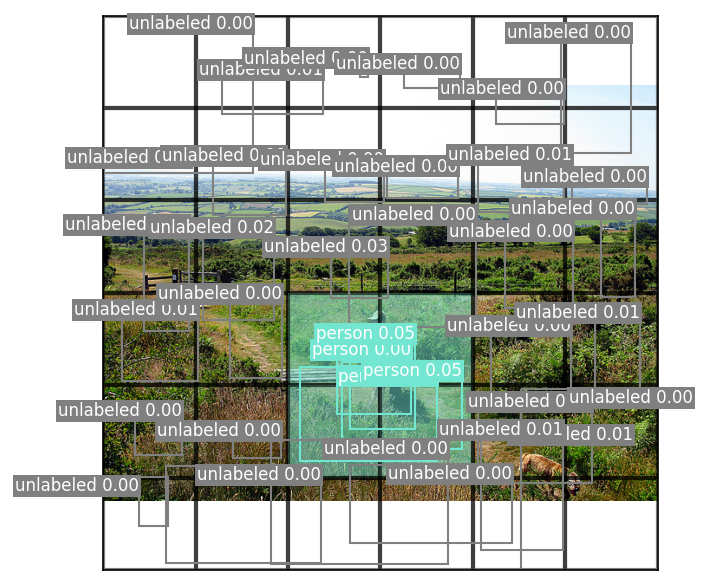

In [132]:
x, y = next(val_ds_iter)
preds = model_reloaded.predict(x)

boxes = preds["box"][0]
classes = np.argmax(preds["class"][0], axis=-1)
path = next(metadata_iter)["path"]
draw_prediction(path, boxes, classes, cutoff=None)

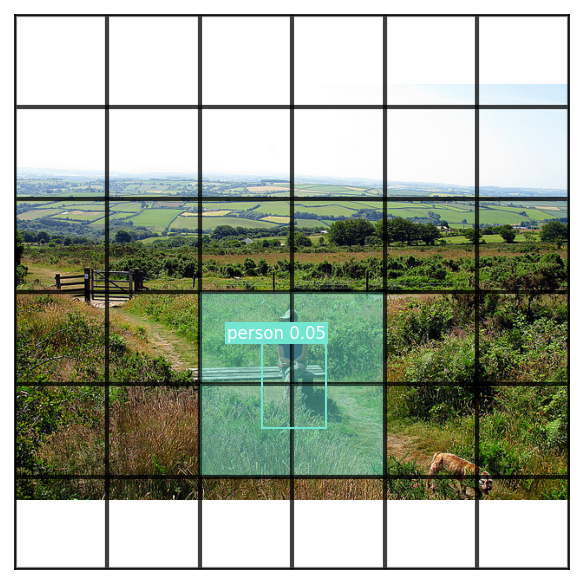

In [135]:
draw_prediction(path, boxes, classes, cutoff=.049)